compress uniform
compress with prior
Advantage: 1
Theoretical accuracy@uniform: 9.5367431640625e-07
Accuracy@uniform: 0.0
Accuracy@prior: 1.0
#bits_uncompressed: 400
#bits_compressed@uniform: 471
#bits_compressed@prior: 422
Compression ratio@uniform: -0.1775
Compression ratio@prior: -0.05499999999999994
Advantage: 10
Theoretical accuracy@uniform: 9.5367431640625e-07
Accuracy@uniform: 0.0
Accuracy@prior: 1.0
#bits_uncompressed: 400
#bits_compressed@uniform: 471
#bits_compressed@prior: 372
Compression ratio@uniform: -0.1775
Compression ratio@prior: 0.06999999999999995
Advantage: 100
Theoretical accuracy@uniform: 9.5367431640625e-07
Accuracy@uniform: 0.0
Accuracy@prior: 1.0
#bits_uncompressed: 400
#bits_compressed@uniform: 471
#bits_compressed@prior: 304
Compression ratio@uniform: -0.1775
Compression ratio@prior: 0.24
Advantage: 1000
Theoretical accuracy@uniform: 9.5367431640625e-07
Accuracy@uniform: 0.0
Accuracy@prior: 1.0
#bits_uncompressed: 400
#bits_compressed@uniform: 471
#bits_compr

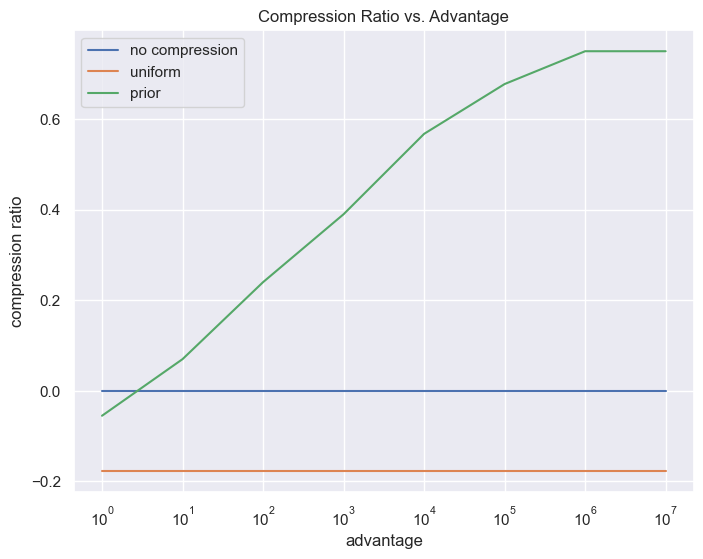

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns


def gen_proba_uniform(rng: np.random.RandomState, n: int, m: int):
    """
    :param n: number of tokens
    :param m: codebook size
    """
    proba_uniform = rng.uniform(size=(n, m))
    proba_uniform /= proba_uniform.sum(axis=1, keepdims=True)
    return proba_uniform


def gen_proba_with_prior(
    rng: np.random.RandomState, tokens: List[int], m: int, advantage: float = 0.5
):
    """
    :param tokens: list of tokens
    :param m: codebook size
    :param advantage: advantage of the prior
    """
    n = len(tokens)
    proba_with_prior = rng.uniform(size=(n, m))
    proba_with_prior[np.arange(n), tokens] += advantage
    proba_with_prior /= proba_with_prior.sum(axis=1, keepdims=True)
    return proba_with_prior


# Compresssion & Decompression Algorithm
def encode(proba: List[int], k: int):
    """
    Encode data k using binary search
    """

    pcsum = proba.cumsum()
    assert np.allclose(pcsum[-1], 1)

    left, right = 0.0, 1.0
    bisection_sequence = []
    # print("target: ", pcsum[k])
    while True:
        mid = (left + right) * 0.5
        # l = np.where(pcsum > mid)
        # a faster way to find the index of the first element that is greater than mid
        idx = np.searchsorted(pcsum, mid, side="right")

        # print("=" * 20)
        # print("pcsum:", pcsum)
        # print("left, right, mid:", left, right, mid)
        # print("bisect idx:", idx)
        # print("k:", k)
        # print("pcsum[idx]:", pcsum[idx])

        if idx < k:
            left = mid
            bisection_sequence.append(1)
        elif idx > k:
            right = mid
            bisection_sequence.append(0)
        else:
            break
        # print("bisection_sequence:", bisection_sequence)

    return bisection_sequence


def decode(proba: List[int], bisection_sequence: List[int]):
    """
    Decode data using binary search
    """

    pcsum = proba.cumsum()
    assert np.allclose(pcsum[-1], 1)

    left, right = 0.0, 1.0
    for bit in bisection_sequence:
        mid = (left + right) * 0.5
        # print("=" * 20)
        # print("left, right, mid:", left, right, mid)
        if bit == 0:
            right = mid
        else:
            left = mid

    mid = (left + right) * 0.5
    idx = np.searchsorted(pcsum, mid, side="right")
    return idx


def do_compress_and_decompress(tokens: List[int], proba: List[List[float]]):
    """
    Compress and decompress a sequence of tokens
    :param tokens: a sequence of tokens
    :param proba: a list of probability distributions of shape (n, m),
        where n is the number of tokens and m is the codebook size
    """

    # to store "the number of compressed bits" of a token, we need at most log2(log2(m)) bits
    # e.g., if codebook size m = 256, the length of the compressed sequence is at most 8 bits,
    # so we need at most 3 bits to represent the length of the compressed sequence
    num_bits_to_represent_num_compressed_bits = int(
        np.ceil(np.log2(np.log2(len(proba[0]))))
    )

    num_bits_compressed = 0

    for i, k0 in enumerate(tokens):
        bisection_sequence = encode(proba[i], k0)
        k1 = decode(proba[i], bisection_sequence)

        assert k0 == k1

        num_bits_compressed += num_bits_to_represent_num_compressed_bits

        num_bits_compressed += len(bisection_sequence)

    return num_bits_compressed


def compress_algorithm_test(
    rng: np.random.RandomState,
    seqlen: int,
    bits_per_token: int,
    advantages: List[float],
):
    """
    :param rng: random number generator
    :param seqlen: sequence length
    :param bits_per_token: bits per token
    :param advantages: advantages of the prior
    """

    # hyperparameters
    n = seqlen
    m = 2**bits_per_token

    # generate tokens
    tokens = rng.randint(m, size=n)

    # generate uniform probability
    proba_uniform = gen_proba_uniform(rng, n, m)

    print("compress uniform")
    num_bits_uncompressed = n * bits_per_token
    num_bits_compressed_uniform = do_compress_and_decompress(tokens, proba_uniform)

    print("compress with prior")
    compression_ratios_with_prior = []
    for advantage in advantages:
        # generate probability with prior
        proba_with_prior = gen_proba_with_prior(rng, tokens, m, advantage=advantage)
        print("=" * 20)
        print("Advantage:", advantage)
        print("Theoretical accuracy@uniform:", 1 / m)
        print("Accuracy@uniform:", np.mean(proba_uniform.argmax(axis=1) == tokens))
        print("Accuracy@prior:", np.mean(proba_with_prior.argmax(axis=1) == tokens))

        num_bits_compressed_with_prior = do_compress_and_decompress(
            tokens, proba_with_prior
        )

        print("#bits_uncompressed:", num_bits_uncompressed)
        print("#bits_compressed@uniform:", num_bits_compressed_uniform)
        print("#bits_compressed@prior:", num_bits_compressed_with_prior)
        compression_ratio_uniform = (
            1 - num_bits_compressed_uniform / num_bits_uncompressed
        )

        print("Compression ratio@uniform:", compression_ratio_uniform)

        cr_prior = 1 - num_bits_compressed_with_prior / num_bits_uncompressed
        compression_ratios_with_prior.append(cr_prior)
        print("Compression ratio@prior:", cr_prior)

    return {
        'cr_uniform': compression_ratio_uniform,
        'cr_prior': compression_ratios_with_prior,
    }



rng = np.random.RandomState(42)
seqlen = 20
bits_per_token = 20
advantages = [10**i for i in range(8)]
rst = compress_algorithm_test(rng, seqlen, bits_per_token, advantages)

# plot the results
sns.set()
plt.figure(figsize=(8, 6))

plt.plot(advantages, np.zeros_like(advantages), label='no compression')
plt.plot(advantages, rst['cr_uniform'] * np.ones_like(advantages), label='uniform')
plt.plot(advantages, rst['cr_prior'], label='prior')

plt.xscale('log')
plt.xlabel('advantage')
plt.ylabel('compression ratio')

plt.title('Compression Ratio vs. Advantage')

plt.legend()
